# Figures 

## SOSE

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
omega_total = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/omega_total_newbins.zarr'))
R1 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/R1_newbins.zarr'))

In [4]:
wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms_newbins.zarr'))
wmt_budget_terms['omega_total'] = omega_total.omega_total
wmt_budget_terms['R1'] = R1.R1
wmt_budget_terms = wmt_budget_terms.sel(time=slice('2006', '2010'))

wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:               (time: 366, sigma2_bin: 99)
Coordinates:
  * time                  (time) datetime64[ns] 2006-01-01 ... 2010-12-31
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 -7.392e+06 ... 0.0
    R1_slt                (time, sigma2_bin) float64 -1.15e+07 ... 0.0
    R1_th                 (time, sigma2_bin) float64 -1.319e+07 ... 0.0
    R2                    (time, sigma2_bin) float64 7.816e+06 8.187e+06 ... 0.0
    R2_slt                (time, sigma2_bin) float64 7.839e+06 8.74e+06 ... 0.0
    R2_th                 (time, sigma2_bin) float64 -9.438e+05 ... 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 -8.895e+06 ... 0.0
    omega_trans_rate      (time, sigma2_bin) float32 -2.822e+07 ... 0.0
    omega_trans_rate_slt  (time, sigma2_bin) float32 -1.935e+07 ... 0.0
    omega_trans_rate_th   (time, sigma2_bin) float32 -8.872e+06 ... 0.0
    psi_adv               (time, sigma2_bin) float32 8.737e+06 8.911e+06 ... 0.0
    psi_vel               (time, sigma2_bin) float64 9.212e+05 ... -0.0

In [5]:
#indices
indices = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/indices.zarr')).load()
deep = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/deep.zarr')).load()
bottom = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/bottom.zarr')).load()

#climatology ds
clim = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/clim_ds.zarr')).load()
#anomalous ds
anom = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/anom_ds.zarr')).load()

## Time mean budgets

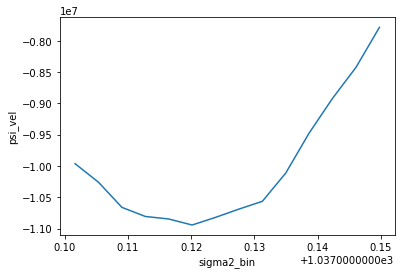

In [6]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.1, 1037.15)).plot()

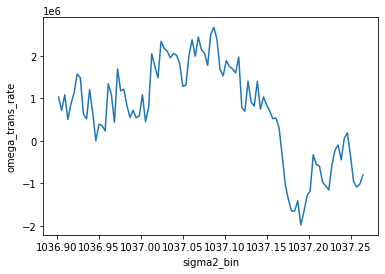

In [7]:
wmt_budget_terms.omega_trans_rate.mean('time').plot()

### $\frac{\partial V}{\partial t}$

In [9]:
#bottom
dVdt_bot = (wmt_budget_terms.dVdt.mean('time')[-1] - 
            wmt_budget_terms.dVdt.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
dVdt_bot.load()

<xarray.DataArray 'dVdt' ()>
array(7.74579268)

In [10]:
#deep
dVdt_deep = (wmt_budget_terms.dVdt.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
              wmt_budget_terms.dVdt.mean('time')[0])/1e6
dVdt_deep.load()

<xarray.DataArray 'dVdt' ()>
array(-7.17507302)

In [11]:
(wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6

0.61963557720304

In [14]:
dVdt_bot + dVdt_deep - (wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6

<xarray.DataArray 'dVdt' ()>
array(-0.04891592)

### E-P-R

In [15]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
#WG model's boundaries after .roll(XC=700) (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #YG=-77.9583
upper_lat = 95
left_lon =  310
right_lon = 880

YG_upper = 95 #-61.9583
XG_left = 311 #295.1667
XG_right = 881 #30.166668

#set the boundaries
lat_range_noface = dict(YC=slice(lower_lat, upper_lat))
lon_range_noface = dict(XC=slice(left_lon, right_lon))

lat_range = dict(YC=slice(lower_lat, upper_lat), YG=slice(lower_lat, YG_upper))
lon_range = dict(XC=slice(left_lon, right_lon), XG=slice(XG_left, XG_right))

fs = gcsfs.GCSFileSystem(requester_pays=True)

mapping = fs.get_mapper('gcs://pangeo-ecco-sose')

ds = xr.open_zarr(mapping, consolidated=True)
ds_wg = ds.roll(XC=700, XG=700).isel(**lat_range, **lon_range)
ds_wg

/tmp/ipykernel_337/1965848097.py:24: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_wg = ds.roll(XC=700, XG=700).isel(**lat_range, **lon_range)


<xarray.Dataset>
Dimensions:   (time: 438, Zl: 42, YC: 95, XC: 570, Z: 42, XG: 570, YG: 95, Zp1: 43, Zu: 42)
Coordinates: (12/26)
    Depth     (YC, XC) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
    PHrefC    (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    PHrefF    (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
  * XC        (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * XG        (XG) float32 295.2 295.3 295.5 295.7 ... 29.5 29.67 29.83 30.0
  * YC        (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    ...        ...
    iter      (time) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    rA        (YC, XC) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
    rAs       (YG, XC) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
    rAw       (YC, XG) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
    rAz       (YG, XG) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables: (12/56)
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    ADVx_SLT  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    ADVx_TH   (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    ADVy_SLT  (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    ADVy_TH   (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    ...        ...
    oceFreez  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    oceQsw    (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    oceTAUX   (time, YC, XG) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    oceTAUY   (time, YG, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    surForcS  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    surForcT  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>

In [16]:
ds_wg.SIempmr

<xarray.DataArray 'SIempmr' (time: 438, YC: 95, XC: 570)>
dask.array<getitem, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    iter     (time) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Ocean surface freshwater flux, > 0 increases salt
    standard_name:  SIempmr
    units:          kg/m^2/s

In [22]:
ds_wg.rA

<xarray.DataArray 'rA' (YC: 95, XC: 570)>
dask.array<getitem, shape=(95, 570), dtype=float32, chunksize=(95, 570), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    rA       (YC, XC) float32 dask.array<chunksize=(95, 570), meta=np.ndarray>
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [17]:
mask = ds_wg.hFacC[0]>0

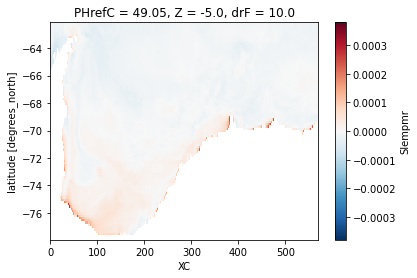

In [19]:
ds_wg.SIempmr.mean(dim='time').where(mask).drop('XC').plot()

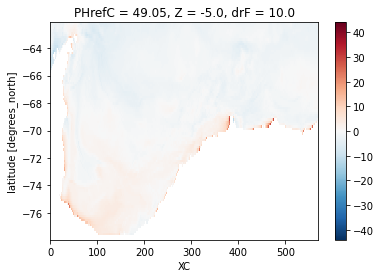

In [21]:
((ds_wg.SIempmr*ds_wg.rA)/1035).mean('time').where(mask).drop('XC').plot()

In [23]:
e_minus_p = (ds_wg.SIempmr * ds_wg.rA) / 1035 #m^3/s
e_minus_p.load()

<xarray.DataArray (time: 438, YC: 95, XC: 570)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ -4.590157  ,  -4.63502   ,  -4.6929173 , ...,  -1.6258342 ,
          -1.5898887 ,  -1.5491401 ],
        [ -4.4775004 ,  -4.4996614 ,  -4.5338473 , ...,  -1.7955439 ,
          -1.7478423 ,  -1.6944572 ],
        [ -4.2735653 ,  -4.303585  ,  -4.33733   , ...,  -1.6204481 ,
          -1.5708538 ,  -1.5142077 ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [ -4.408534  ,  -4.3782682 ,  -4.338693  , ..., -29.30797   ,
         -29.473768  , -29.581987  ],
        [ -4.3784266 ,  -4.364892  ,  -4.327309  , ..., -29.292774  ,
         -29.456676  , -29.727255  ],
        [ -4.4558415 ,  -4.457199  ,  -4.4067125 , ..., -29.302591  ,
         -29.640717  , -29.760035  ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ -8.693349  ,  -8.615664  ,  -8.522566  , ..., -31.488506  ,
         -31.673683  , -31.90505   ],
        [ -8.83045   ,  -8.814941  ,  -8.766588  , ..., -31.515768  ,
         -31.699339  , -31.855545  ],
        [ -8.926923  ,  -8.976619  ,  -8.966006  , ..., -31.938972  ,
         -32.163383  , -32.259663  ]]], dtype=float32)
Coordinates:
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5.191e+03 5.185e+03 5.179e+03
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    iter     (time) int64 480 960 1440 1920 2400 ... 208800 209280 209760 210240
    rA       (YC, XC) float32 7.212e+07 7.212e+07 ... 1.601e+08 1.601e+08
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [25]:
sigma2_vars = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/sigma2.zarr'))
sigma2 = sigma2_vars.sigma2

delta_sigma = 3.7e-3
sigma_bins = np.arange(1036.9, 1037.27, delta_sigma)

/tmp/ipykernel_337/4204911040.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  sigma2_vars = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/sigma2.zarr'))


In [28]:
fw = (- histogram(sigma2.isel(Z=0).rename('sigma2'), bins=[sigma_bins],
                 weights=e_minus_p.fillna(0.),
                 dim=['XC', 'YC']) / (- delta_sigma)).load()
fw

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 99)>
array([[ 1.0890070e+03, -9.8168613e+03,  2.2582145e+04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-6.5357065e+03, -1.5607757e+04, -1.5824773e+04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.8306182e+04,  2.5591344e+04,  2.0401172e+04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-8.2924488e+05, -7.2092488e+05, -8.8032750e+05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.3030046e+06, -1.0625094e+06, -1.2000430e+06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-6.6615106e+05, -6.1022569e+05, -7.7063988e+05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

### $\Psi$

In [29]:
psi_bot = (wmt_budget_terms.psi_vel.mean('time')[-1] - 
           wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
psi_bot.load()

<xarray.DataArray 'psi_vel' ()>
array(10.94345)

In [30]:
fw_bot = (fw.mean('time')[-1] - fw.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
fw_bot.load()

<xarray.DataArray 'histogram_sigma2' ()>
array(-0.12583401)

In [31]:
psi_deep = (wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
            wmt_budget_terms.psi_vel.mean('time')[0])/1e6
psi_deep.load()

<xarray.DataArray 'psi_vel' ()>
array(-10.29433995)

In [32]:
fw_deep = (fw.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
            fw.mean('time')[0])/1e6
fw_deep.load()

<xarray.DataArray 'histogram_sigma2' ()>
array(0.03008407)

In [33]:
(wmt_budget_terms.R2.mean('time')[-1] - wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray 'R2' ()>
array(1.72049609)

In [35]:
#residual from transport in (deep wm) and out (bottom wm) after considering E-P-2 and R2 term
psi_bot + psi_deep #+ fw_bot + fw_deep + (wmt_budget_terms.R2.mean('time')[-1] - wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray 'psi_vel' ()>
array(0.64911005)

In [38]:
#residual from transport in (deep wm) and out (bottom wm) after considering E-P-2 and R2 term
psi_bot + psi_deep + fw_bot + fw_deep #- (wmt_budget_terms.R2.mean('time')[-1] + wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray ()>
array(0.55336012)

### $\Omega$

In [39]:
#bottom
omega_bot = (wmt_budget_terms.omega_trans_rate.mean('time')[-1] - 
             wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
omega_bot.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(-1.591318)

In [ ]:
#deep
omega_deep = (wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
              wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6
omega_deep.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(-0.24150906)

In [44]:
omega_bot + omega_deep

<xarray.DataArray 'omega_trans_rate' ()>
array(-1.83282706)

In [36]:
(wmt_budget_terms.omega_trans_rate.mean('time')[-1] - wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(0.47923504)

### Budget

In [45]:
dVdt_bot

<xarray.DataArray 'dVdt' ()>
array(7.74579268)

In [46]:
psi_bot + omega_bot + fw_bot

<xarray.DataArray ()>
array(9.226298)

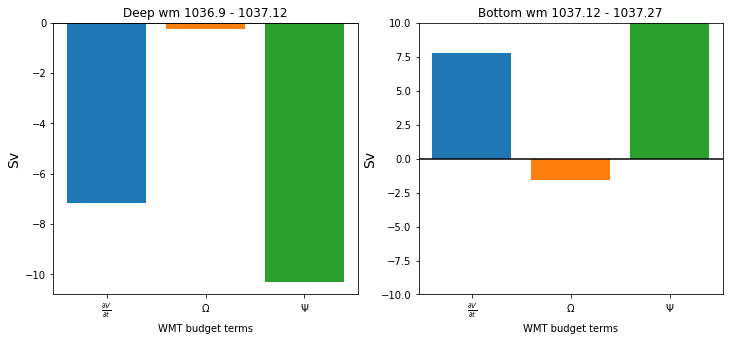

In [49]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = dVdt_deep)
ax0.bar(x=r'$\Omega$', height = omega_deep)
ax0.bar(x=r'$\Psi$', height=psi_deep)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = dVdt_bot)
ax1.bar(x=r'$\Omega$', height = omega_bot)
ax1.bar(x=r'$\Psi$', height=psi_bot)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')

plt.ylim(-10,10);

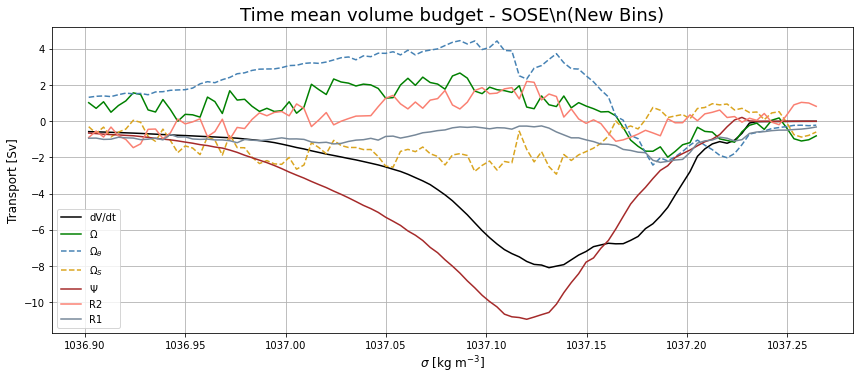

In [11]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Time mean volume budget - SOSE\n(New Bins)', fontsize=18);

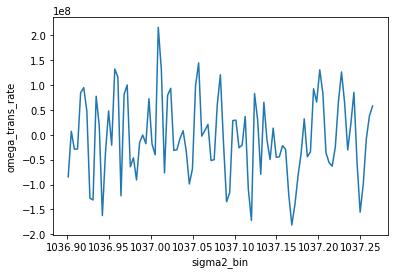

In [12]:
wmt_budget_terms.omega_trans_rate.differentiate('sigma2_bin').mean('time').plot()

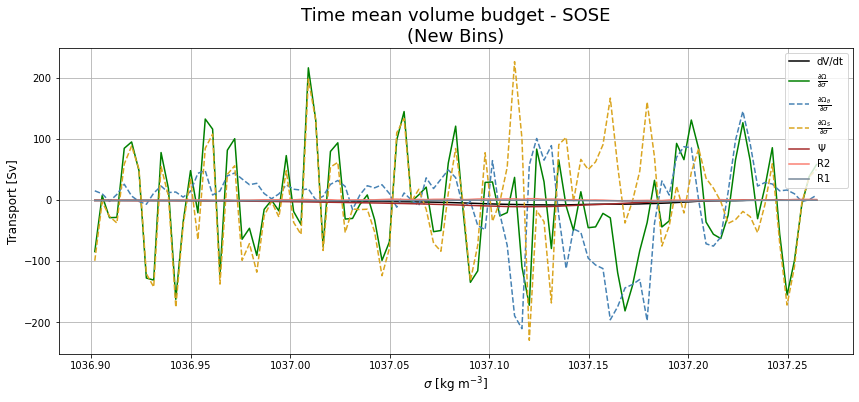

In [41]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label=r'$\frac{\partial \Omega}{\partial \sigma}$',
                                                                                          color='green')
(wmt_budget_terms.omega_trans_rate_th/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label=
                                                                                             r'$\frac{\partial \Omega_{\theta}}{\partial \sigma}$',
                                                                                             color='steelblue', linestyle='dashed')
(wmt_budget_terms.omega_trans_rate_slt/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label=r'$\frac{\partial \Omega_S}{\partial \sigma}$',
                                                                                              color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title('Time mean volume budget - SOSE\n(New Bins)', fontsize=18);

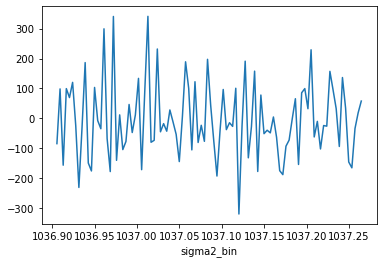

In [22]:
((wmt_budget_terms.omega_trans_rate.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin'))/1e6).mean('time').plot()

In [61]:
def d_dsigma(da):
    """d/dsigma function to switch to formation view"""
    da = (da.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin')) / 1e6
    return da

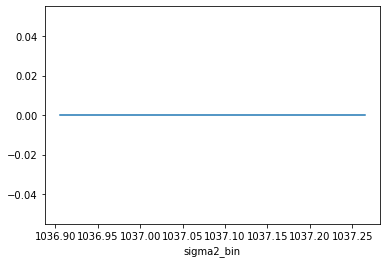

In [63]:
#check function works
(((wmt_budget_terms.omega_trans_rate.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin'))/1e6) - 
 d_dsigma(wmt_budget_terms.omega_trans_rate)).mean('time').plot();
#it works

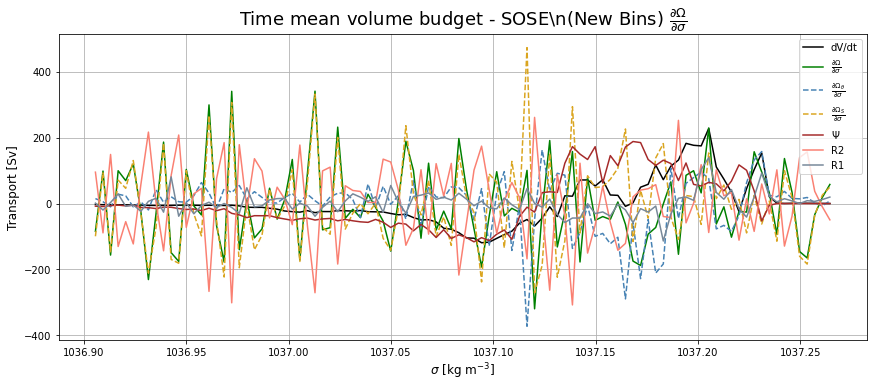

In [64]:
d_dsigma(wmt_budget_terms.dVdt).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
d_dsigma(wmt_budget_terms.omega_trans_rate).mean(dim='time').plot(label=r'$\frac{\partial \Omega}{\partial \sigma}$',
                                                                  color='green')
d_dsigma(wmt_budget_terms.omega_trans_rate_th).mean(dim='time').plot(label=r'$\frac{\partial \Omega_{\theta}}{\partial \sigma}$',
                                                                        color='steelblue', linestyle='dashed')
d_dsigma(wmt_budget_terms.omega_trans_rate_slt).mean(dim='time').plot(label=r'$\frac{\partial \Omega_S}{\partial \sigma}$',
                                                                      color='goldenrod', linestyle='dashed')
d_dsigma(wmt_budget_terms.psi_vel).mean(dim='time').plot(label=r'$\Psi$', color='brown')
d_dsigma(wmt_budget_terms.R2).mean(dim='time').plot(label='R2', color='salmon')
d_dsigma(wmt_budget_terms.R1).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Time mean volume budget - SOSE\n(New Bins) $\frac{\partial \Omega}{\partial \sigma}$', fontsize=18);

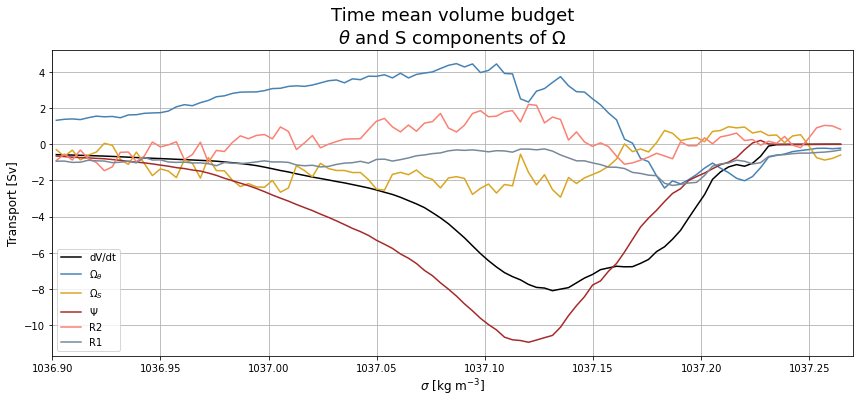

In [8]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue')
(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.ylim(-12, 12)
plt.xlim(1036.90, 1037.27)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title("Time mean volume budget\n" r'$\theta$ and S components of $\Omega$', fontsize=18);

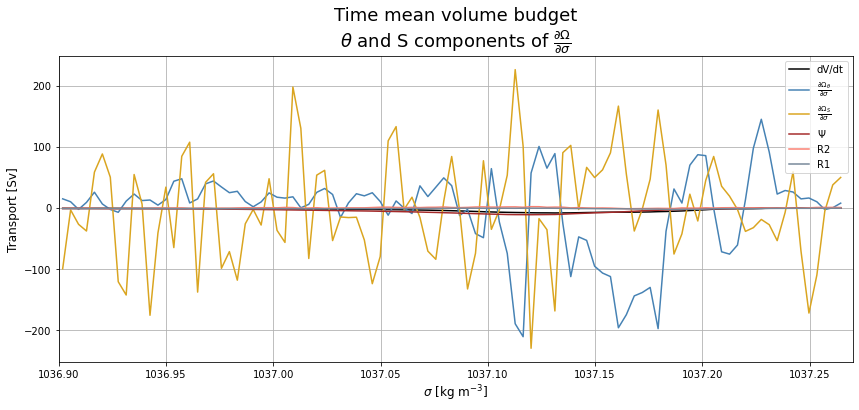

In [43]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate_th/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label=
                                                                                             r'$\frac{\partial \Omega_{\theta}}{\partial \sigma}$',
                                                                                             color='steelblue')
(wmt_budget_terms.omega_trans_rate_slt/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label=r'$\frac{\partial \Omega_S}{\partial \sigma}$',
                                                                                              color='goldenrod')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.ylim(-12, 12)
plt.xlim(1036.90, 1037.27)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title("Time mean volume budget\n" r'$\theta$ and S components of $\frac{\partial \Omega}{\partial \sigma}$', fontsize=18);

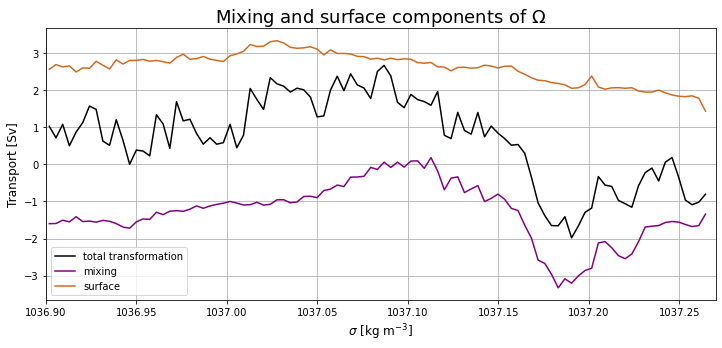

In [9]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k')#, marker='.')
(wmt_budget_terms.omega_mix/1e6).mean(dim='time').plot(label='mixing', color='purple')
(wmt_budget_terms.omega_surf/1e6).mean(dim='time').plot(label='surface', color='chocolate')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Mixing and surface components of $\Omega$', fontsize=18);

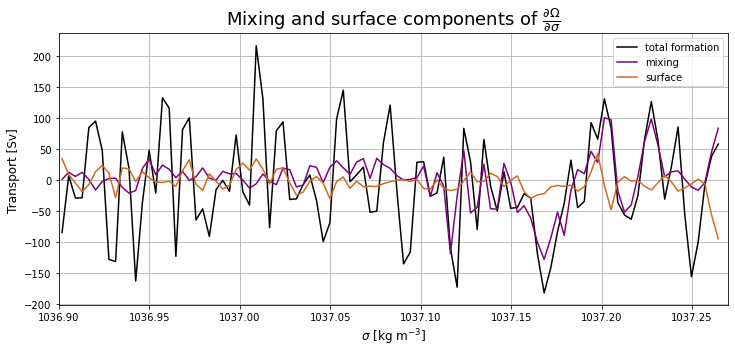

In [44]:
(wmt_budget_terms.omega_trans_rate/1e6).differentiate('sigma2_bin').mean(dim='time').plot(figsize=(12,5), label='total formation', color='k')
(wmt_budget_terms.omega_mix/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label='mixing', color='purple')
(wmt_budget_terms.omega_surf/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label='surface', color='chocolate')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Mixing and surface components of $\frac{\partial \Omega}{\partial \sigma}$', fontsize=18);

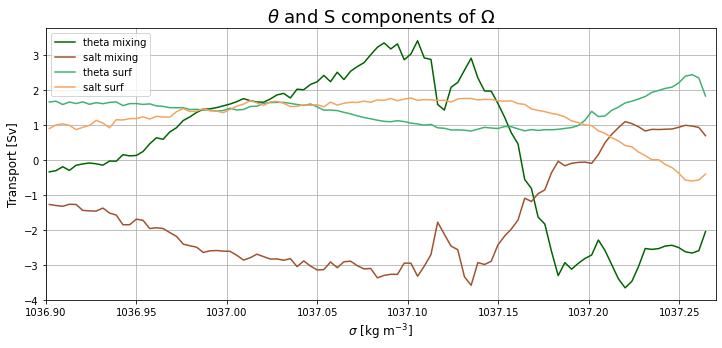

In [10]:
(wmt_budget_terms.omega_mix_th/1e6).mean(dim='time').plot(figsize=(12,5), label='theta mixing', color='darkgreen')
(wmt_budget_terms.omega_mix_slt/1e6).mean(dim='time').plot(label='salt mixing', color='sienna')
(wmt_budget_terms.omega_surf_th/1e6).mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(wmt_budget_terms.omega_surf_slt/1e6).mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'$\theta$ and S components of $\Omega$', fontsize=18);

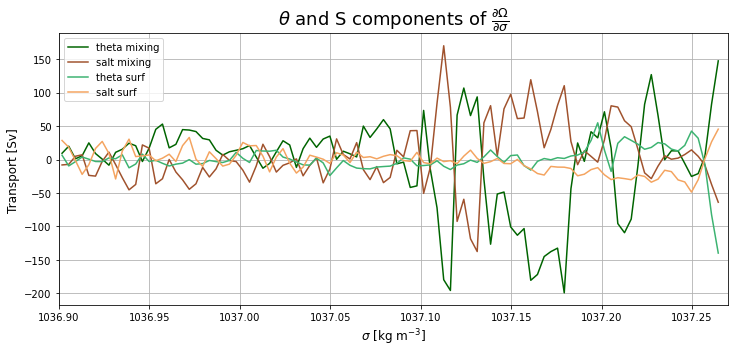

In [45]:
(wmt_budget_terms.omega_mix_th/1e6).differentiate('sigma2_bin').mean(dim='time').plot(figsize=(12,5), label='theta mixing', color='darkgreen')
(wmt_budget_terms.omega_mix_slt/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label='salt mixing', color='sienna')
(wmt_budget_terms.omega_surf_th/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(wmt_budget_terms.omega_surf_slt/1e6).differentiate('sigma2_bin').mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'$\theta$ and S components of $\frac{\partial \Omega}{\partial \sigma}$', fontsize=18);

## Monthly Climatology

In [50]:
clim

<xarray.Dataset>
Dimensions:           (month: 12, sigma2_bin: 99)
Coordinates:
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * sigma2_bin        (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
Data variables:
    R1                (month, sigma2_bin) float64 -2.37 -2.077 ... -0.006441
    R2                (month, sigma2_bin) float64 -2.811 -2.8 ... 0.003102
    dVdt              (month, sigma2_bin) float64 -16.72 -16.59 ... -0.02164
    omega_mix         (month, sigma2_bin) float32 -6.315 -6.494 ... -0.01647
    omega_surf_slt    (month, sigma2_bin) float32 -2.003 -1.943 ... 0.0 0.0
    omega_surf_th     (month, sigma2_bin) float32 -4.877 -4.944 ... -0.008462
    omega_trans_rate  (month, sigma2_bin) float32 -12.68 -12.86 ... -0.02494
    psi_vel           (month, sigma2_bin) float64 -0.4061 -0.4329 ... 0.0 0.0

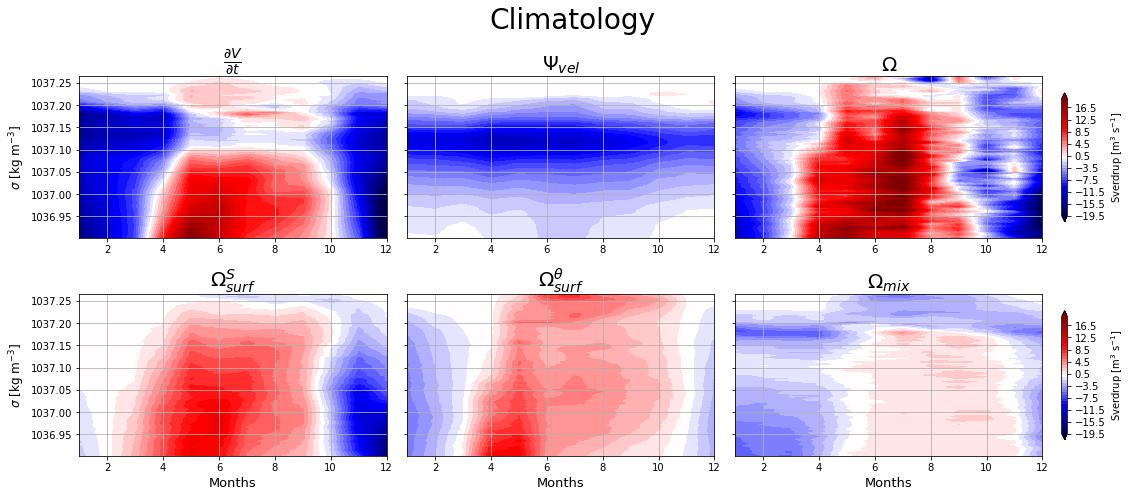

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-20, 20) + 0.5

c = ax[0,0].contourf(clim.dVdt.month, 
                   clim.dVdt.sigma2_bin, 
                   clim.dVdt.T, cmap='seismic', levels=levels, extend='both')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].grid()

c_psi = ax[0,1].contourf(clim.psi_vel.month, clim.psi_vel.sigma2_bin, clim.psi_vel.T,
                         cmap='seismic', levels=levels, extend='both')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
ax[0,1].grid()

c_omega = ax[0,2].contourf(clim.omega_trans_rate.month, clim.omega_trans_rate.sigma2_bin, clim.omega_trans_rate.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20)
ax[0,2].grid()

c_surf_slt = ax[1,0].contourf(clim.omega_surf_slt.month, 
                                clim.omega_surf_slt.sigma2_bin, 
                                clim.omega_surf_slt.T, cmap='seismic', levels=levels, extend='both')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Months', fontsize=13)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
ax[1,0].grid()

c_surf_th = ax[1,1].contourf(clim.omega_surf_th.month, clim.omega_surf_th.sigma2_bin, 
                        clim.omega_surf_th.T, cmap='seismic', levels=levels, extend='both')
ax[1,1].set_xlabel('Months', fontsize=13)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
ax[1,1].grid()

c_mix = ax[1,2].contourf(clim.omega_mix.month, clim.omega_mix.sigma2_bin, clim.omega_mix.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Months', fontsize=13)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
ax[1,2].grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [52]:
dVdt_clim_deep = clim.dVdt.sel(sigma2_bin=1037.12, method='nearest') - clim.dVdt.isel(sigma2_bin=0)
dVdt_clim_deep.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([  1.85306328,  -0.28583405,  -5.57086422, -19.02362308,
       -21.00289961, -15.63288559,  -9.37353414,  -7.09945501,
        -5.83283734,  -6.98586704,  -6.03449533,   8.34334153])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [53]:
dVdt_clim_bot = clim.dVdt.isel(sigma2_bin=-1) - clim.dVdt.sel(sigma2_bin=1037.12, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([14.85701916, 12.82427842, 12.65862737, 10.39358888,  1.31005742,
        2.20149207,  1.6468298 ,  1.19824706,  1.81634544,  5.94051744,
       12.4464429 , 15.00336608])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

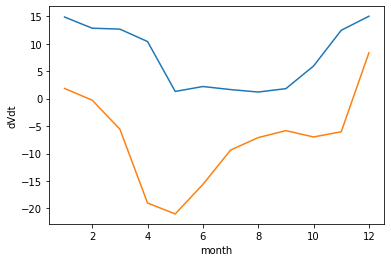

In [54]:
dVdt_clim_bot.plot()
dVdt_clim_deep.plot();

### $\Psi$

In [55]:
psi_clim_deep = clim.psi_vel.sel(sigma2_bin=1037.12, method='nearest') - clim.psi_vel.isel(sigma2_bin=0)
psi_clim_deep.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([-10.71802437, -10.54790637, -11.64483727, -12.26259497,
       -11.97624739, -10.74687783, -10.96362328, -10.57379167,
        -9.61654429,  -8.51236393,  -7.85776867,  -8.08513551])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [56]:
psi_clim_bot = clim.psi_vel.isel(sigma2_bin=-1) - clim.psi_vel.sel(sigma2_bin=1037.12, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([11.1241416 , 10.99302675, 11.50757157, 12.97978515, 12.93795025,
       12.50778247, 12.78110659, 11.60070815, 10.43112935,  8.91415043,
        7.75598673,  7.89383709])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

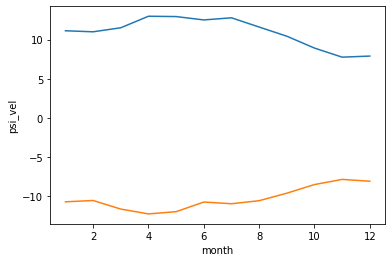

In [57]:
psi_clim_bot.plot()
psi_clim_deep.plot();

### $\Omega$

In [58]:
omega_clim_deep = clim.omega_trans_rate.sel(sigma2_bin=1037.12, method='nearest') - clim.omega_trans_rate.isel(sigma2_bin=0)
omega_clim_deep.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([  6.825916 ,   4.9927883,  -1.2110457, -14.400014 ,  -5.267436 ,
        -4.9290013,   3.5846205,   1.6964176,  -5.9395275,  -5.6273565,
         5.0453033,  11.7315645], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [59]:
omega_clim_bot = clim.omega_trans_rate.isel(sigma2_bin=-1) - clim.omega_trans_rate.sel(sigma2_bin=1037.12, method='nearest')
omega_clim_bot.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([  5.855032 ,   3.501884 ,   2.2294838,   0.4533924, -12.486283 ,
        -6.5772276, -11.074621 , -15.274399 ,   1.5483826,   0.441226 ,
         4.6442094,   7.211331 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

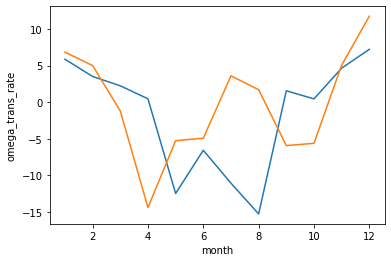

In [60]:
omega_clim_bot.plot()
omega_clim_deep.plot();

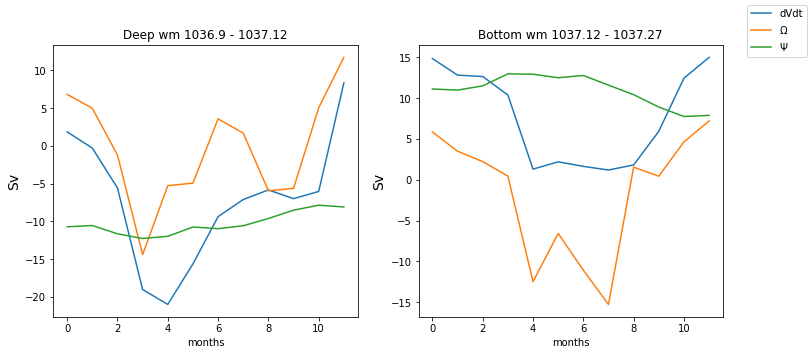

In [62]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_clim_deep, label='dVdt')
ax0.plot(omega_clim_deep, label=r'$\Omega$')
ax0.plot(psi_clim_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_clim_bot)#, label='dVdt')
ax1.plot(omega_clim_bot)#, label=r'$\Omega$')
ax1.plot(psi_clim_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();

## Anomaly

In [67]:
anom['time'] = pd.to_datetime(anom.time)
anom

<xarray.Dataset>
Dimensions:           (time: 366, sigma2_bin: 99)
Coordinates:
  * sigma2_bin        (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time              (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
Data variables:
    R1                (time, sigma2_bin) float64 nan nan nan ... 0.3865 0.3141
    R2                (time, sigma2_bin) float64 nan nan nan ... -1.014 -0.8315
    dVdt              (time, sigma2_bin) float64 nan nan ... 0.001724 0.0008233
    omega_mix         (time, sigma2_bin) float32 nan nan nan ... 1.649 1.342
    omega_surf_slt    (time, sigma2_bin) float32 nan nan nan ... 0.5665 0.3989
    omega_surf_th     (time, sigma2_bin) float32 nan nan nan ... -2.348 -1.833
    omega_trans_rate  (time, sigma2_bin) float32 nan nan nan ... 1.024 0.8098
    psi_vel           (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0

In [64]:
import warnings
warnings.filterwarnings("ignore")

In [65]:
year_start_index =[0,73, 146, 220, 293]

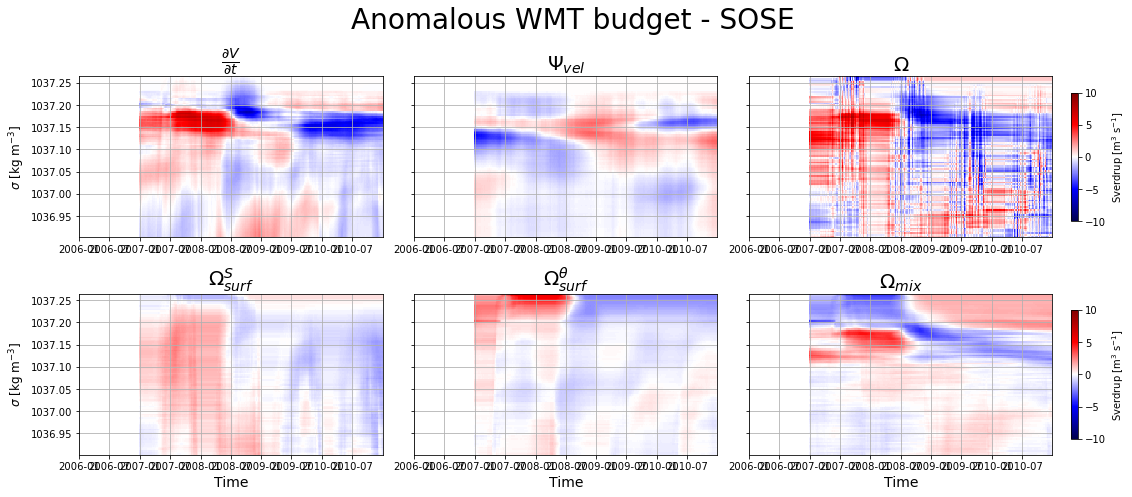

In [72]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()

c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20)
#ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
#ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.5)
#ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
#ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()

plt.suptitle('Anomalous WMT budget - SOSE', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [73]:
dVdt_anom_deep = anom.dVdt.sel(sigma2_bin=1037.12, method='nearest') - anom.dVdt.isel(sigma2_bin=0)
dVdt_anom_deep.load()

<xarray.DataArray 'dVdt' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  2.17791347,  2.07086615,  1.97369278,
        1.94996124,  2.01332481,  1.98574582,  1.84570586,  1.71608463,
        1.61118235,  1.60314699,  1.76334344,  1.86790525,  1.82943086,
        1.79892373,  1.71717417,  1.7140077 ,  1.6985839 ,  1.61887722,
        1.61748125,  1.54781878,  1.52800276,  1.70426993,  2.01104358,
        2.00253155,  2.15530551,  2.09830894,  1.42272595,  1.09416149,
...
       -2.05535978, -2.10578506, -2.092302  , -2.08195137, -2.02597624,
       -1.98253083, -2.07061334, -2.12863135, -2.12342199, -2.12434129,
       -2.09740922, -2.04354508, -2.03819952, -2.0468137 , -2.01225485,
       -1.90381155, -1.9811689 , -1.77476914, -1.42485651, -1.18543006,
       -1.06857688, -1.1145078 , -1.16445641, -1.36435298, -1.3586329 ,
       -1.36642992, -1.49914953, -1.59206687, -1.58372508, -1.68246466,
       -1.69441555, -1.56826723, -1.56098093, -1.62345925, -1.64218572,
       -1.641675  , -1.57174014, -1.44297011, -1.35962029, -1.31331484,
       -1.26050619, -1.14395944, -0.98583992, -1.00613261, -0.87756687,
       -0.69261743, -0.74484726, -1.03830809, -1.15243742, -1.18757509,
       -1.25771424, -1.56673507, -1.8300633 , -1.95352182, -2.14347634,
       -2.23384007, -2.23210362, -2.29590982, -2.17088508, -2.1286654 ,
       -2.07926156, -2.07469912, -1.99999752, -2.00023586, -1.95777784,
       -1.88208884, -1.89587834, -1.89911291, -1.84323993, -1.84729166,
       -1.80129263, -1.7026552 , -1.70588977, -1.65134467, -1.54773621,
       -1.43707979, -1.38859525, -1.40650457, -1.37844891, -1.33459492,
       -1.2784836 , -1.18413623, -0.95540089, -0.82312391, -0.72642722,
       -0.64804843, -0.59302665, -0.45935369, -0.33667828, -0.32768957,
       -0.55346272, -0.78839482, -1.04933968, -1.10790247, -0.98607826,
       -0.91382813])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31

In [74]:
dVdt_anom_bot = anom.dVdt.isel(sigma2_bin=-1) - anom.dVdt.sel(sigma2_bin=1037.12, method='nearest')
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -1.42283663, -1.35564064, -1.32507359,
       -1.28959826, -1.24585495, -1.20514093, -1.13531173, -1.07729371,
       -0.9500218 , -0.88509202, -0.93875187, -0.94729795, -0.90883146,
       -0.92853743, -0.87205159, -0.87416257, -0.88512607, -0.86772747,
       -0.86711461, -0.8881223 , -0.89871127, -0.94219073, -1.03211184,
       -1.18066384, -1.29206932, -1.24923677, -0.77764729, -0.62545214,
...
        1.34857543,  1.45874741,  1.5165506 ,  1.57475932,  1.59060362,
        1.61959854,  1.74390827,  1.83883445,  1.89130262,  1.94925254,
        1.98078111,  1.91217412,  1.86793818,  1.85238561,  1.83999209,
        1.70744272,  1.61891758,  1.54510124,  1.51009976,  1.5421731 ,
        1.6166704 ,  1.53444417,  1.38282785,  1.43318503,  1.46267071,
        1.54833581,  1.62412695,  1.66815118,  1.6221862 ,  1.74026512,
        1.80155175,  1.83416986,  1.92150331,  1.96760448,  2.0108456 ,
        1.99654539,  1.9471756 ,  1.94520081,  2.01751904,  2.02637155,
        2.06344997,  2.07260891,  2.0955914 ,  2.22790243,  2.29334294,
        2.28592045,  2.30808578,  2.41727813,  2.42361108,  2.44308661,
        2.54931678,  2.61870687,  2.64342581,  2.68138947,  2.7492474 ,
        2.7873813 ,  2.78591723,  2.86872229,  2.77045938,  2.69507682,
        2.56429796,  2.4878599 ,  2.43532364,  2.4278671 ,  2.41618859,
        2.37744182,  2.34669636,  2.32596105,  2.25238304,  2.23675495,
        2.19613553,  2.12912881,  2.1210594 ,  2.04972857,  1.93141132,
        1.85378158,  1.82313826,  1.83171839,  1.83260364,  1.78612795,
        1.73651982,  1.71561427,  1.75739133,  1.69790924,  1.68279187,
        1.71701024,  1.78599175,  1.79368663,  1.79593381,  1.76760576,
        1.7914735 ,  1.79879385,  1.76825268,  1.70696605,  1.66992168,
        1.67662916])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31

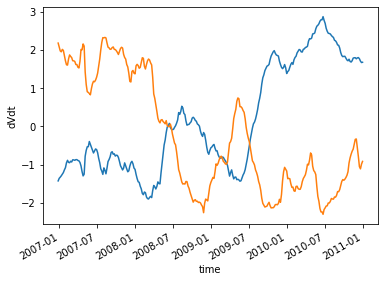

In [75]:
dVdt_anom_bot.plot()
dVdt_anom_deep.plot();

### $\Psi$

In [76]:
psi_anom_deep = anom.psi_vel.sel(sigma2_bin=1037.12, method='nearest') - anom.psi_vel.isel(sigma2_bin=0)
psi_anom_deep.load()

<xarray.DataArray 'psi_vel' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -4.71195545, -4.6480426 , -4.61501936,
       -4.55510934, -4.49456167, -4.4479568 , -4.4132124 , -4.40775389,
       -4.43106168, -4.39414316, -4.35055344, -4.33496974, -4.28079286,
       -4.24419965, -4.18214634, -4.12598183, -4.04502341, -3.98413646,
       -3.8989874 , -3.80789461, -3.71200209, -3.69076802, -3.66818094,
       -3.65135124, -3.61499774, -3.57129995, -3.53613852, -3.52406199,
...
        1.68651138,  1.62679816,  1.64970355,  1.5810634 ,  1.6069242 ,
        1.6108748 ,  1.60034697,  1.63837202,  1.71370326,  1.73399707,
        1.73633512,  1.72964703,  1.74078329,  1.75951013,  1.73488318,
        1.74745551,  1.798199  ,  1.88092766,  1.90384094,  1.89791545,
        1.85882064,  1.85210338,  1.80937776,  1.77721691,  1.74719607,
        1.71524659,  1.66710001,  1.69017355,  1.67246814,  1.62300629,
        1.66041084,  1.65178824,  1.62528221,  1.60351048,  1.56618883,
        1.54632057,  1.5431067 ,  1.56946227,  1.52222433,  1.49958926,
        1.43476425,  1.43983591,  1.44984746,  1.43768127,  1.48702856,
        1.59866073,  1.61059638,  1.64622116,  1.69749746,  1.70454643,
        1.68933039,  1.66296817,  1.59430926,  1.59171683,  1.54253378,
        1.49467887,  1.49145911,  1.43904134,  1.46521217,  1.49576491,
        1.50856356,  1.52978816,  1.54300457,  1.56137361,  1.55445195,
        1.54963604,  1.5602372 ,  1.59203327,  1.66214526,  1.6854582 ,
        1.74300293,  1.77875166,  1.87794782,  1.93956123,  2.04471879,
        2.11676469,  2.22031932,  2.20701042,  2.1966835 ,  2.20495189,
        2.20781772,  2.23071841,  2.3111804 ,  2.3005915 ,  2.31264525,
        2.32121207,  2.32748286,  2.34810047,  2.37367921,  2.3407418 ,
        2.33236648,  2.35315695,  2.35492615,  2.36607289,  2.35855134,
        2.38228436])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31

In [77]:
psi_anom_bot = anom.psi_vel.isel(sigma2_bin=-1) - anom.psi_vel.sel(sigma2_bin=1037.12, method='nearest')
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  4.26730371,  4.19672259,  4.18602709,
        4.18450341,  4.13880273,  4.11250449,  4.07774833,  4.07390673,
        4.13645656,  4.08743077,  4.05650909,  4.04947818,  3.9695996 ,
        3.95446457,  3.88440497,  3.80269686,  3.74058897,  3.7116289 ,
        3.62108085,  3.61284318,  3.59489783,  3.58388592,  3.59262488,
        3.59879791,  3.5846585 ,  3.55671994,  3.6182366 ,  3.63193121,
...
       -1.40298309, -1.32933376, -1.33885803, -1.30225848, -1.31615718,
       -1.311444  , -1.29235308, -1.37828798, -1.45052901, -1.47201318,
       -1.45408761, -1.42727208, -1.4334719 , -1.47033591, -1.43010591,
       -1.45695672, -1.51242926, -1.54542038, -1.56975265, -1.52749804,
       -1.49263257, -1.43270787, -1.38923174, -1.29887523, -1.25364569,
       -1.1797225 , -1.10581119, -1.11767381, -1.09814544, -1.0374404 ,
       -1.04220034, -0.99675928, -0.97376662, -0.94302166, -0.93830343,
       -0.95013281, -0.98128393, -0.98375529, -0.96708362, -0.99493779,
       -1.00129326, -1.03468919, -1.06744333, -1.07972044, -1.14420385,
       -1.21829758, -1.167466  , -1.14159819, -1.18229956, -1.22281229,
       -1.15932255, -1.1300652 , -1.14968876, -1.13964368, -1.0974036 ,
       -1.12185985, -1.11405893, -1.07955364, -1.11177159, -1.1333557 ,
       -1.1709968 , -1.19696399, -1.23407654, -1.30834662, -1.36616217,
       -1.37138764, -1.42974073, -1.49687892, -1.61698164, -1.66211026,
       -1.74275754, -1.80438162, -1.92975846, -1.99892728, -2.13908783,
       -2.21224561, -2.29917704, -2.30189352, -2.26867729, -2.32736167,
       -2.30897833, -2.36553922, -2.47056138, -2.51051994, -2.57435099,
       -2.60632215, -2.62331773, -2.72186217, -2.79997963, -2.82189635,
       -2.80594711, -2.81982035, -2.84397348, -2.88962946, -2.9018663 ,
       -2.91480071])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31

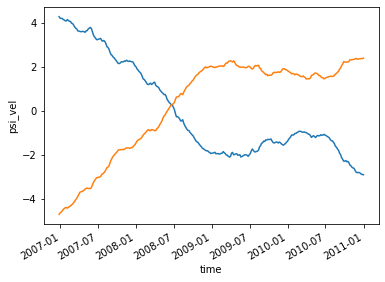

In [78]:
psi_anom_bot.plot()
psi_anom_deep.plot();

### $\Omega$

In [79]:
omega_anom_deep = anom.omega_trans_rate.sel(sigma2_bin=1037.12, method='nearest') - anom.omega_trans_rate.isel(sigma2_bin=0)
omega_anom_deep.load()

<xarray.DataArray 'omega_trans_rate' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  5.933042  ,  5.8357573 ,  5.7076077 ,
        5.5134416 ,  5.506198  ,  5.4415183 ,  5.2772236 ,  5.4209404 ,
        5.4246187 ,  5.4380665 ,  5.3656473 ,  5.397048  ,  5.4492645 ,
        4.991954  ,  5.0128593 ,  4.828368  ,  4.661042  ,  4.5756826 ,
        4.5902905 ,  4.229565  ,  4.0527134 ,  4.7482634 ,  4.5720806 ,
        4.6209183 ,  4.7255697 ,  4.3311977 ,  4.0794077 ,  3.2061877 ,
...
       -3.5867417 , -2.9354641 , -0.725689  , -2.2181363 , -2.5714717 ,
       -1.5021896 , -2.0708654 , -2.9018002 , -3.606228  , -2.4802835 ,
       -0.13237906, -0.57720816, -1.5852324 , -2.8522272 , -0.6698764 ,
       -1.6708508 , -1.5979859 , -1.6657034 ,  0.03278685, -0.7853639 ,
        0.373271  ,  0.2750098 ,  0.7148303 ,  0.43020117,  0.6080388 ,
        0.4343524 ,  0.2752105 ,  0.32348216,  0.3354076 ,  0.3131764 ,
        0.57400274,  0.22661722,  0.560779  ,  0.30244458,  0.6072618 ,
        0.44329774,  0.184708  , -0.87844545,  0.9130912 ,  0.63560236,
        0.74961686,  1.0684067 ,  0.91886723,  1.1338046 ,  1.032245  ,
        1.1288255 ,  1.0118569 ,  0.7288388 , -1.77152   ,  1.7002943 ,
        0.37382603, -0.60779727,  3.040672  , -2.5532284 , -3.0850224 ,
       -0.87668383, -2.9614048 , -0.858636  , -0.5919459 , -2.1137266 ,
       -1.415405  , -1.8167057 , -2.5187464 , -2.7794569 ,  0.09934855,
       -2.5551372 , -2.30592   , -2.5174549 , -3.8556457 , -1.511891  ,
       -0.64275575, -0.89975643, -1.4106996 , -1.3849131 , -0.52544296,
       -0.36743474, -1.822532  ,  0.22234154, -0.6512998 , -1.4275153 ,
       -2.4468148 , -0.6705879 , -1.8911772 , -1.6891519 , -2.8070846 ,
       -1.3618009 , -1.6557661 , -2.0704372 , -2.4610505 , -2.5681286 ,
       -2.9483802 , -4.242232  , -3.3161454 , -3.755774  , -4.747219  ,
       -4.372554  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31

In [80]:
omega_anom_bot = anom.omega_trans_rate.isel(sigma2_bin=-1) - anom.omega_trans_rate.sel(sigma2_bin=1037.12, method='nearest')
omega_anom_bot.load()

<xarray.DataArray 'omega_trans_rate' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -5.195685  , -5.2715    , -5.2612934 ,
       -5.2529993 , -5.178793  , -5.1024013 , -5.1211777 , -5.097136  ,
       -5.101915  , -5.0925736 , -5.1207957 , -5.0663295 , -5.0344577 ,
       -5.134689  , -5.0445523 , -5.108808  , -4.9593644 , -5.0024705 ,
       -4.839763  , -4.8663287 , -4.9453416 , -4.6908197 , -4.8689146 ,
       -5.175464  , -4.8980684 , -4.8827744 , -5.611746  , -4.2647333 ,
...
        5.3569336 ,  4.711414  ,  2.001628  ,  4.1673417 ,  3.972183  ,
        3.2048817 ,  2.9908528 ,  4.9817266 ,  5.478588  ,  4.79987   ,
        2.430704  ,  2.1210709 ,  2.4789252 ,  3.5859842 ,  1.8421546 ,
        2.5738719 ,  2.7169635 ,  1.464656  ,  2.2580645 ,  2.4834595 ,
        2.4510689 ,  1.5656612 ,  1.9535967 ,  1.9638648 ,  1.9470712 ,
        1.934737  ,  1.9259902 ,  1.8943168 ,  1.8910222 ,  1.9010422 ,
        1.9011707 ,  1.9179919 ,  1.9196389 ,  1.9492064 ,  1.9641728 ,
        1.9658201 ,  1.9769237 ,  1.9993659 ,  2.1777627 ,  2.2243466 ,
        2.3265476 ,  2.4889617 ,  2.4236035 ,  2.235736  ,  2.2737746 ,
        1.7575523 ,  2.1157622 ,  2.3483725 ,  3.1235147 ,  3.3693666 ,
        2.602801  ,  3.057562  ,  3.8026485 ,  2.7968197 ,  2.9944692 ,
        3.6282523 ,  2.755548  ,  2.9920814 ,  3.8791175 ,  3.9684083 ,
        3.5728486 ,  2.911618  ,  3.1718736 ,  3.664209  ,  3.757378  ,
        3.7108164 ,  3.7594125 ,  4.2546825 ,  4.9910803 ,  3.4482143 ,
        3.2903686 ,  3.4163241 ,  3.3597434 ,  2.7412806 ,  2.7749977 ,
        2.912091  ,  3.0097044 ,  2.2079477 ,  1.5406396 ,  4.5675564 ,
        3.6255422 ,  3.4250927 ,  3.1875591 ,  3.889443  ,  5.036146  ,
        3.769128  ,  3.7572663 ,  5.068925  ,  5.164197  ,  5.380003  ,
        5.026067  ,  4.9543962 ,  5.3212585 ,  5.11024   ,  5.0954494 ,
        5.0659313 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31

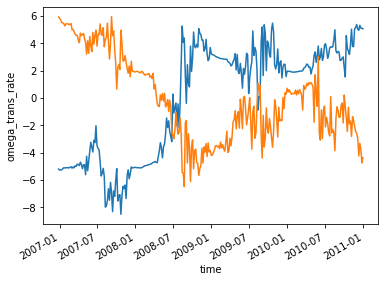

In [81]:
omega_anom_bot.plot()
omega_anom_deep.plot();

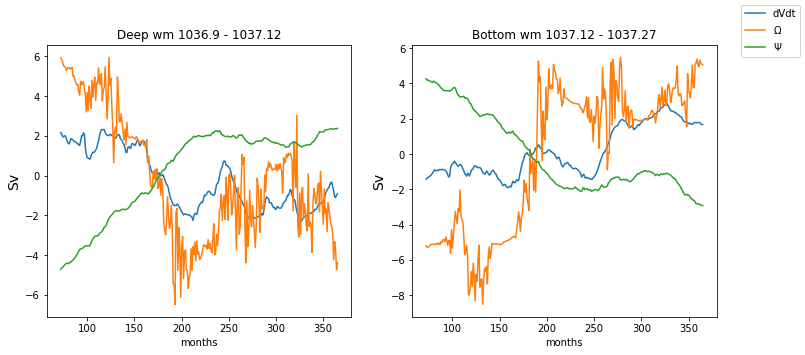

In [82]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_anom_deep, label='dVdt')
ax0.plot(omega_anom_deep, label=r'$\Omega$')
ax0.plot(psi_anom_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_anom_bot)#, label='dVdt')
ax1.plot(omega_anom_bot)#, label=r'$\Omega$')
ax1.plot(psi_anom_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();

## Indices

In [94]:
indices

<xarray.Dataset>
Dimensions:          (time: 60)
Coordinates:
  * time             (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    enso             (time) float32 -0.7034 -0.6278 -0.392 ... -1.47 -1.44
    fw_flx           (time) float32 0.06174 0.3266 -0.6006 ... -0.1008 0.9542
    heat_flx         (time) float32 0.9099 0.5741 0.6695 ... 0.2288 -0.04812
    sam              (time) float64 0.1723 -1.534 1.666 ... 3.167 3.901 0.09625
    sose             (time) float32 -0.1024 -0.3163 -0.7164 ... -0.4328 -0.4636
    windstress_curl  (time) float32 0.1545 0.4456 0.4518 ... -2.025 -0.3768

In [112]:
deep

<xarray.Dataset>
Dimensions:           (time: 366)
Coordinates:
  * time              (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
Data variables:
    R1                (time) float64 nan nan nan nan ... -0.9546 -1.244 -1.39
    R2                (time) float64 nan nan nan nan ... -0.2517 -0.316 -0.2989
    dVdt              (time) float64 nan nan nan nan ... -1.206 -1.268 -1.269
    omega_mix         (time) float64 nan nan nan nan ... -2.17 -2.288 -2.185
    omega_surf_slt    (time) float64 nan nan nan nan ... -1.7 -1.757 -1.786
    omega_surf_th     (time) float64 nan nan nan nan ... -0.3095 -0.2313 -0.1964
    omega_trans_rate  (time) float64 nan nan nan nan ... -1.444 -1.438 -1.455
    psi_vel           (time) float64 nan nan nan nan ... 2.301 2.378 2.42 2.432

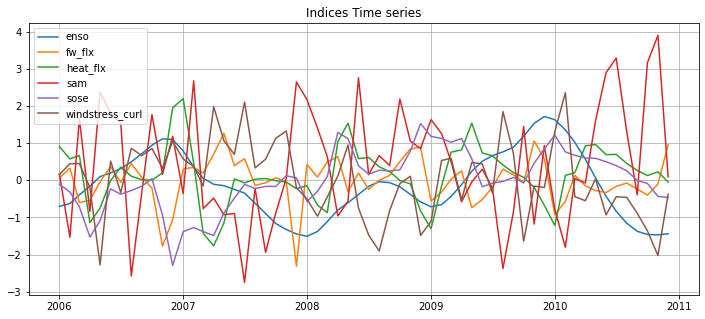

In [111]:
fig, ax = plt.subplots(figsize=(12,5))
for i in indices.variables:
    if i =='time':
        continue
    ax.plot(indices.time, indices[i], label=f'{indices[i].name}')
    
plt.legend()
plt.grid()
plt.title('Indices Time series');

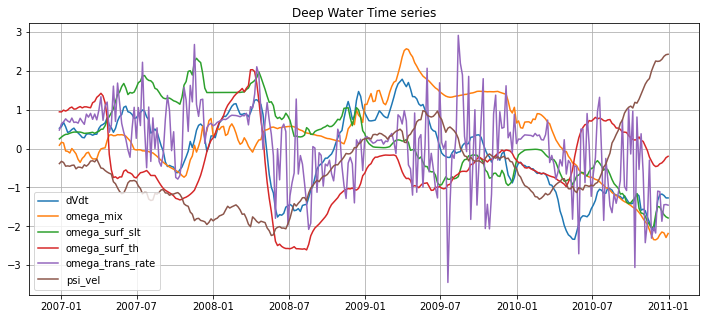

In [119]:
fig, ax = plt.subplots(figsize=(12,5))
for i in deep.variables:
    if i =='time':
        continue
    if i=='R1':
        continue
    if i=='R2':
        continue
    ax.plot(deep.time, deep[i], label=f'{deep[i].name}')
    
plt.legend()
plt.grid()
plt.title('Deep Water Time series');

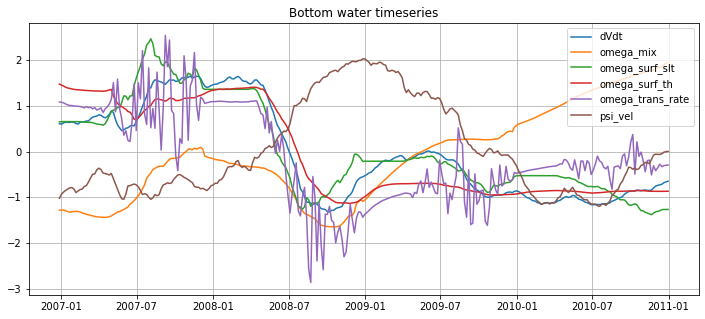

In [118]:
fig, ax = plt.subplots(figsize=(12,5))
for i in bottom.variables:
    if i =='time':
        continue
    if i=='R1':
        continue
    if i=='R2':
        continue
    ax.plot(bottom.time, bottom[i], label=f'{bottom[i].name}')
    
plt.legend()
plt.grid()
plt.title('Bottom water timeseries');

## Heat map of Corralation matrices

In [134]:
import seaborn as sn

In [122]:
indices_df = indices.to_dataframe()
indices_df.head()

enso    fw_flx  heat_flx       sam      sose  windstress_curl
time                                                                         
2006-01-01 -0.703412  0.061736  0.909883  0.172308 -0.102403         0.154478
2006-02-01 -0.627783  0.326616  0.574079 -1.533846 -0.316302         0.445615
2006-03-01 -0.392023 -0.600639  0.669474  1.665538 -0.716384         0.451785
2006-04-01 -0.160018 -0.538129 -1.137979 -0.839846 -1.526455        -0.196582
2006-05-01  0.099242 -0.036327 -0.748289  2.373692 -1.089656        -2.279050

### Deep Water Corr Matrix

In [126]:
deep.resample(time='MS').mean()

<xarray.Dataset>
Dimensions:           (time: 60)
Coordinates:
  * time              (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    R1                (time) float64 nan nan nan nan ... -1.046 -1.65 -1.368
    R2                (time) float64 nan nan nan nan ... -1.124 -0.1339 -0.1639
    dVdt              (time) float64 nan nan nan nan ... -1.347 -1.826 -1.321
    omega_mix         (time) float64 nan nan nan nan ... -1.575 -2.048 -2.238
    omega_surf_slt    (time) float64 nan nan nan nan ... -1.39 -1.88 -1.65
    omega_surf_th     (time) float64 nan nan nan nan ... 0.2499 -0.1241 -0.3431
    omega_trans_rate  (time) float64 nan nan nan nan ... -0.2611 -1.599 -1.511
    psi_vel           (time) float64 nan nan nan nan ... 0.808 1.197 1.814 2.327

In [129]:
deep_df = deep.resample(time='MS').mean().to_dataframe()
deep_df.head()

R1  R2  dVdt  omega_mix  omega_surf_slt  omega_surf_th  \
time                                                                 
2006-01-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-02-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-03-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-04-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-05-01 NaN NaN   NaN        NaN             NaN            NaN   

            omega_trans_rate  psi_vel  
time                                   
2006-01-01               NaN      NaN  
2006-02-01               NaN      NaN  
2006-03-01               NaN      NaN  
2006-04-01               NaN      NaN  
2006-05-01               NaN      NaN

In [132]:
deep_ind = pd.concat([deep_df, indices_df], axis=1)
deep_ind.tail()

R1        R2      dVdt  omega_mix  omega_surf_slt  \
time                                                                  
2010-08-01 -0.732610  0.669280 -1.101533  -1.100016       -0.727832   
2010-09-01 -0.820570 -0.743931 -1.273671  -1.336341       -1.227721   
2010-10-01 -1.045891 -1.123883 -1.346818  -1.574599       -1.390394   
2010-11-01 -1.649880 -0.133936 -1.825993  -2.048247       -1.880278   
2010-12-01 -1.368065 -0.163927 -1.320854  -2.237861       -1.650450   

            omega_surf_th  omega_trans_rate   psi_vel      enso    fw_flx  \
time                                                                        
2010-08-01       0.666261         -1.121124 -0.003222 -1.156375 -0.074501   
2010-09-01       0.438083         -0.374826  0.807966 -1.372571 -0.232771   
2010-10-01       0.249915         -0.261085  1.197432 -1.459237 -0.402171   
2010-11-01      -0.124135         -1.599207  1.813592 -1.470133 -0.100824   
2010-12-01      -0.343129         -1.511382  2.327367 -1.439778  0.954187   

            heat_flx       sam      sose  windstress_curl  
time                                                       
2010-08-01  0.452923  1.304531  0.256971        -0.459329  
2010-09-01  0.265406 -0.392656 -0.005690        -0.887641  
2010-10-01  0.126579  3.167031 -0.085412        -1.363300  
2010-11-01  0.228844  3.901406 -0.432815        -2.025066  
2010-12-01 -0.048120  0.096250 -0.463637        -0.376755

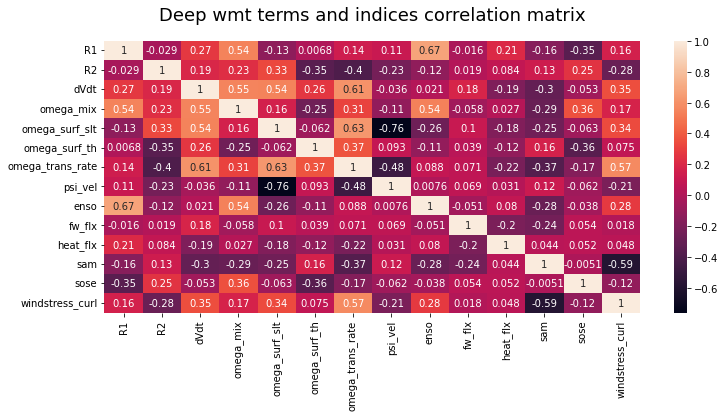

In [143]:
plt.figure(figsize=(12,5))
sn.heatmap(deep_ind.corr(), annot=True)
plt.title('Deep wmt terms and indices correlation matrix', fontsize=18, pad=20.5);

### Bottom Waterr Corr Matrix

In [144]:
bottom_df = bottom.resample(time='MS').mean().to_dataframe()
bottom_df.head()

R1  R2  dVdt  omega_mix  omega_surf_slt  omega_surf_th  \
time                                                                 
2006-01-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-02-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-03-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-04-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-05-01 NaN NaN   NaN        NaN             NaN            NaN   

            omega_trans_rate  psi_vel  
time                                   
2006-01-01               NaN      NaN  
2006-02-01               NaN      NaN  
2006-03-01               NaN      NaN  
2006-04-01               NaN      NaN  
2006-05-01               NaN      NaN

In [145]:
bottom_ind = pd.concat([bottom_df, indices_df], axis=1)
bottom_ind.tail()

R1        R2      dVdt  omega_mix  omega_surf_slt  \
time                                                                  
2010-08-01  1.137889 -0.206450 -1.101051   1.493661       -0.909198   
2010-09-01  1.177008 -0.826916 -0.955202   1.582155       -1.076844   
2010-10-01  1.214533 -1.365893 -0.858221   1.675813       -1.196864   
2010-11-01  1.244309 -0.734295 -0.838756   1.758919       -1.344753   
2010-12-01  1.273887 -0.576407 -0.705304   1.878033       -1.285423   

            omega_surf_th  omega_trans_rate   psi_vel      enso    fw_flx  \
time                                                                        
2010-08-01      -0.877245         -0.468518 -1.019885 -1.156375 -0.074501   
2010-09-01      -0.866691         -0.212309 -0.588181 -1.372571 -0.232771   
2010-10-01      -0.858611          0.028833 -0.362851 -1.459237 -0.402171   
2010-11-01      -0.864762         -0.310078 -0.213766 -1.470133 -0.100824   
2010-12-01      -0.870608         -0.326588 -0.035743 -1.439778  0.954187   

            heat_flx       sam      sose  windstress_curl  
time                                                       
2010-08-01  0.452923  1.304531  0.256971        -0.459329  
2010-09-01  0.265406 -0.392656 -0.005690        -0.887641  
2010-10-01  0.126579  3.167031 -0.085412        -1.363300  
2010-11-01  0.228844  3.901406 -0.432815        -2.025066  
2010-12-01 -0.048120  0.096250 -0.463637        -0.376755

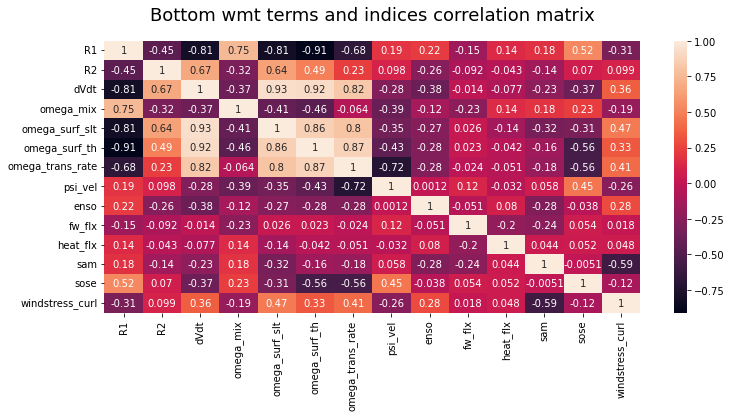

In [146]:
plt.figure(figsize=(12,5))
sn.heatmap(bottom_ind.corr(), annot=True)
plt.title('Bottom wmt terms and indices correlation matrix', fontsize=18, pad=20.5);

### Correlation matrix of all terms (deep, bottom, indices)

In [153]:
corr_matrix = pd.concat([deep_df, bottom_df, indices_df], axis=1)
#corr_matrix = pd.concat([deep_ind, bottom_df], axis=1)
corr_matrix.head()

R1  R2  dVdt  omega_mix  omega_surf_slt  omega_surf_th  \
time                                                                 
2006-01-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-02-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-03-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-04-01 NaN NaN   NaN        NaN             NaN            NaN   
2006-05-01 NaN NaN   NaN        NaN             NaN            NaN   

            omega_trans_rate  psi_vel  R1  R2  ...  omega_surf_slt  \
time                                           ...                   
2006-01-01               NaN      NaN NaN NaN  ...             NaN   
2006-02-01               NaN      NaN NaN NaN  ...             NaN   
2006-03-01               NaN      NaN NaN NaN  ...             NaN   
2006-04-01               NaN      NaN NaN NaN  ...             NaN   
2006-05-01               NaN      NaN NaN NaN  ...             NaN   

            omega_surf_th  omega_trans_rate  psi_vel      enso    fw_flx  \
time                                                                       
2006-01-01            NaN               NaN      NaN -0.703412  0.061736   
2006-02-01            NaN               NaN      NaN -0.627783  0.326616   
2006-03-01            NaN               NaN      NaN -0.392023 -0.600639   
2006-04-01            NaN               NaN      NaN -0.160018 -0.538129   
2006-05-01            NaN               NaN      NaN  0.099242 -0.036327   

            heat_flx       sam      sose  windstress_curl  
time                                                       
2006-01-01  0.909883  0.172308 -0.102403         0.154478  
2006-02-01  0.574079 -1.533846 -0.316302         0.445615  
2006-03-01  0.669474  1.665538 -0.716384         0.451785  
2006-04-01 -1.137979 -0.839846 -1.526455        -0.196582  
2006-05-01 -0.748289  2.373692 -1.089656        -2.279050  

[5 rows x 22 columns]

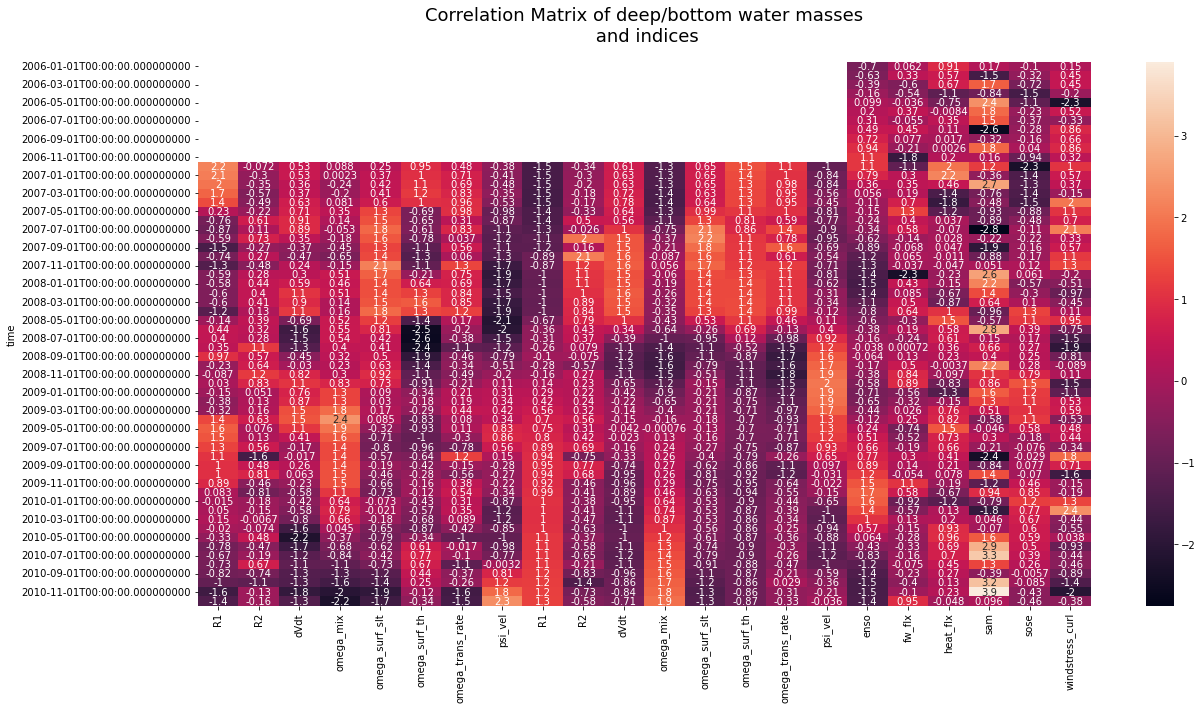

In [154]:
plt.figure(figsize=(20,10))
sn.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of deep/bottom water masses\n and indices', fontsize=18, pad=20.5);